# Necessary imports

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import glob
import random
import cv2
import os
import splitfolders
import keras
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.metrics import MeanIoU
from keras import applications
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from tifffile import imsave
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
mmscaler = MinMaxScaler()

# Trainloader

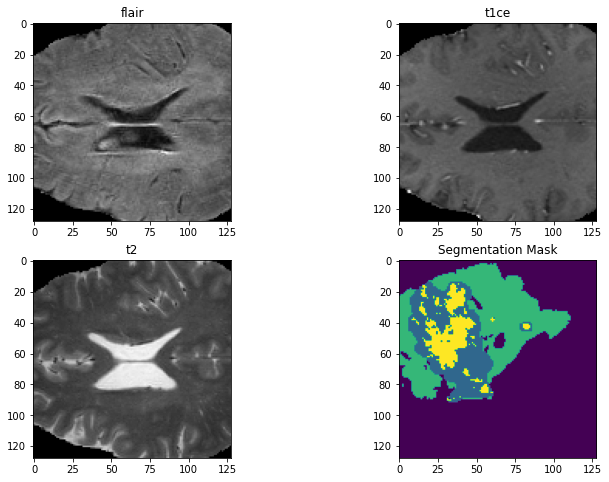

In [15]:
def load_img(img_dir, images_list):
    images=[]
    for i, image_name in enumerate(images_list):    
        if (image_name.split('.')[1] == 'npy'):
            
            image = np.load(img_dir+image_name)
                      
            images.append(image)
    images = np.array(images)
    
    return(images)




def imageLoader(img_dir, images_list, mask_dir, mask_list, batch_size):

    L = len(images_list)
  
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
                       
            X = load_img(img_dir, images_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            yield (X,Y)     

            batch_start += batch_size   
            batch_end += batch_size


#Test the generator
training_data_path_images = "BraTS2020_TrainingData/input_data_128/train/images/"
training_data_path_masks = "BraTS2020_TrainingData/input_data_128/train/masks/"
training_images_list=os.listdir(training_data_path_images)
training_masks_list = os.listdir(training_data_path_masks)

batch_size = 2

training_images_datagenerator = imageLoader(training_data_path_images, training_images_list, 
                                training_data_path_masks, training_masks_list, batch_size)

img, msk = training_images_datagenerator.__next__()


num = random.randint(0,img.shape[0]-1)
test_img=img[num]
test_seg_mask=msk[num]
test_seg_mask=np.argmax(test_seg_mask, axis=3)

n_slice=random.randint(0, test_seg_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('t2')
plt.subplot(224)
plt.imshow(test_seg_mask[:,:,n_slice])
plt.title('Segmentation Mask')
plt.show()

# Customizing pretrained 3D VGG-16 model for Brain Tumor segmentation

In [1]:
from classification_models_3D.tfkeras import Classifiers

vgg16, preprocess_input = Classifiers.get('vgg16')

In [4]:
kernel_initializer =  'he_uniform'
model = vgg16(input_shape=(128, 128, 128, 3),weights='imagenet')
model1 = Sequential()
model1.add(Model(model.input, model.output))
model1.add(Conv3DTranspose(256, (2, 2, 2), strides=(2, 2, 2),kernel_initializer=kernel_initializer, padding='same'))
model1.add(Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2),kernel_initializer=kernel_initializer, padding='same'))
model1.add(Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2),kernel_initializer=kernel_initializer, padding='same'))
model1.add(Conv3DTranspose(8, (2, 2, 2), strides=(2, 2, 2),kernel_initializer=kernel_initializer, padding='same'))
model1.add(Conv3DTranspose(4, (2, 2, 2), strides=(2, 2, 2),kernel_initializer=kernel_initializer, padding='same'))
model1.add(Conv3D(4, (1, 1, 1), activation='softmax'))

In [16]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 4, 4, 4, 512)      44135616  
                                                                 
 conv3d_transpose (Conv3DTra  (None, 8, 8, 8, 256)     1048832   
 nspose)                                                         
                                                                 
 conv3d_transpose_1 (Conv3DT  (None, 16, 16, 16, 128)  262272    
 ranspose)                                                       
                                                                 
 conv3d_transpose_2 (Conv3DT  (None, 32, 32, 32, 32)   32800     
 ranspose)                                                       
                                                                 
 conv3d_transpose_3 (Conv3DT  (None, 64, 64, 64, 8)    2056      
 ranspose)                                              

In [17]:
#training
#images and masks are 128x128x128x3
training_data_path_images = "BraTS2020_TrainingData/input_data_128/train/images/"
training_data_path_masks = "BraTS2020_TrainingData/input_data_128/train/masks/"

images_list = os.listdir(training_data_path_images)
masks_list = os.listdir(training_data_path_masks)

image_count = len(os.listdir(training_data_path_images))

#Define the image generators for training and validation

training_data_path_images = "BraTS2020_TrainingData/input_data_128/train/images/"
training_data_path_masks = "BraTS2020_TrainingData/input_data_128/train/masks/"

validation_data_path_images = "BraTS2020_TrainingData/input_data_128/val/images/"
validation_data_path_masks = "BraTS2020_TrainingData/input_data_128/val/masks/"
 
training_images_list=os.listdir(training_data_path_images)
training_masks_list = os.listdir(training_data_path_masks)

validation_images_list=os.listdir(validation_data_path_images)
validation_masks_list = os.listdir(validation_data_path_masks)

#training
batch_size = 2
training_images_datagenerator = imageLoader(training_data_path_images, training_images_list, 
                                training_data_path_masks, training_masks_list, batch_size)

validation_images_datagenerator = imageLoader(validation_data_path_images, validation_images_list, 
                                validation_data_path_masks, validation_masks_list, batch_size)

In [18]:
#Define loss, metrics and optimizer to be used for training
import segmentation_models_3D as sm
import tensorflow as tf
dice_l = sm.losses.DiceLoss(class_weights=np.array([0.25, 0.25, 0.25, 0.25])) #dice loss
focal_l = sm.losses.CategoricalFocalLoss() 

#focal loss
total_l = dice_l + (1 * focal_l) #total loss
cce = tf.keras.losses.CategoricalCrossentropy()
metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]
LR = 0.0001
model_optimizer = Adam(LR)


#Fitting the model
steps_per_epoch = len(training_images_list)//batch_size
val_steps_per_epoch = len(validation_images_list)//batch_size


model = model1

model.compile(optimizer = model_optimizer, loss=cce, metrics=metrics)
print(model.summary())

print(model.input_shape)
print(model.output_shape)

history=model.fit(training_images_datagenerator,
          steps_per_epoch=steps_per_epoch,
          epochs=1,
          verbose=1,
          validation_data=validation_images_datagenerator,
          validation_steps=val_steps_per_epoch,
          )

Segmentation Models: using `tf.keras` framework.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 4, 4, 4, 512)      44135616  
                                                                 
 conv3d_transpose (Conv3DTra  (None, 8, 8, 8, 256)     1048832   
 nspose)                                                         
                                                                 
 conv3d_transpose_1 (Conv3DT  (None, 16, 16, 16, 128)  262272    
 ranspose)                                                       
                                                                 
 conv3d_transpose_2 (Conv3DT  (None, 32, 32, 32, 32)   32800     
 ranspose)                                                       
                                                                 
 conv3d_transpose_3 (Conv3DT  (None, 64, 64, 64, 8)    2056      
 ranspo

In [19]:
history=model.fit(training_images_datagenerator,
          steps_per_epoch=steps_per_epoch,
          epochs=5,
          verbose=1,
          validation_data=validation_images_datagenerator,
          validation_steps=val_steps_per_epoch,
          )

Epoch 1/5
129/129 [==============================] - 909s 7s/step - loss: 0.3123 - accuracy: 0.9479 - iou_score: 0.2359 - val_loss: 0.2736 - val_accuracy: 0.9503 - val_iou_score: 0.2434
Epoch 2/5
129/129 [==============================] - 909s 7s/step - loss: 0.2546 - accuracy: 0.9520 - iou_score: 0.2380 - val_loss: 0.2516 - val_accuracy: 0.9503 - val_iou_score: 0.2434
Epoch 3/5
129/129 [==============================] - 909s 7s/step - loss: 0.2413 - accuracy: 0.9520 - iou_score: 0.2380 - val_loss: 0.2442 - val_accuracy: 0.9503 - val_iou_score: 0.2434
Epoch 4/5
129/129 [==============================] - 909s 7s/step - loss: 0.2352 - accuracy: 0.9520 - iou_score: 0.2380 - val_loss: 0.2399 - val_accuracy: 0.9503 - val_iou_score: 0.2434
Epoch 5/5
129/129 [==============================] - 909s 7s/step - loss: 0.2310 - accuracy: 0.9520 - iou_score: 0.2380 - val_loss: 0.2367 - val_accuracy: 0.9503 - val_iou_score: 0.2434


In [20]:
model.save('brats_vgg16_3d_transfer_learning.hdf5')

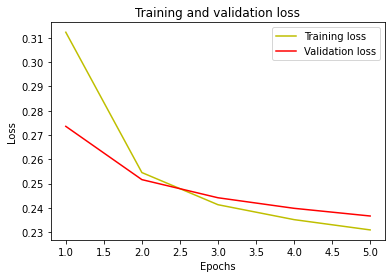

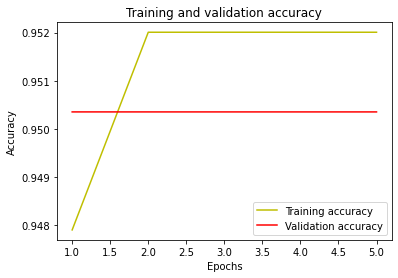

In [21]:
#plotting training and val IoU and loss for each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Prediction

In [ ]:
my_model = load_model('brats_vgg16_3d_transfer_learning.hdf5', 
                      compile=False)



batch_size=8 
test_img_datagen = imageLoader(validation_data_path_images, validation_images_list, 
                                validation_data_path_masks, validation_masks_list, batch_size)


test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = my_model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

#Predict one at a time for few test images
#Try images: 
img_num = 82
test_img = np.load("./BraTS2020_TrainingData/input_data_128/val/images/image_"+str(img_num)+".npy")

test_mask = np.load("./BraTS2020_TrainingData/input_data_128/val/masks/mask_"+str(img_num)+".npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = my_model.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]


#Verification (printing individual slices from test predictions)
n_slice = 30
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()